In [1]:
# Install required packages
!pip install -q kaggle pandas numpy matplotlib seaborn scikit-learn

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, auc, 
                           precision_recall_curve, accuracy_score, precision_score, 
                           recall_score, f1_score)
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Packages installed and imported successfully!")

✅ Packages installed and imported successfully!


In [2]:
# Configuration for both datasets
DATASET_CONFIG = {
    'telco': {
        'path': 'blastchar/telco-customer-churn',
        'file': 'WA_Fn-UseC_-Telco-Customer-Churn.csv',
        'target': 'Churn',
        'description': 'Predict customer churn',
        'delimiter': ','
    },
    'customer': {
        'path': 'imakash3011/customer-personality-analysis',
        'file': 'marketing_campaign.csv', 
        'target': 'Response',
        'description': 'Predict customer behavior',
        'delimiter': '\t'
    }
}

def setup_kaggle():
    """Setup Kaggle credentials"""
    from pathlib import Path
    import shutil
    
    kaggle_dir = Path.home() / ".kaggle"
    kaggle_dir.mkdir(exist_ok=True)
    
    # Copy kaggle.json if exists
    kaggle_json = Path("kaggle.json")
    if kaggle_json.exists():
        shutil.copy(kaggle_json, kaggle_dir / "kaggle.json")
        os.chmod(kaggle_dir / "kaggle.json", 0o600)
        print("✅ Kaggle setup complete")
    else:
        print("⚠️ Please upload kaggle.json")

def choose_dataset():
    """Let user choose which dataset to use"""
    print("\n🎯 Available Datasets:")
    print("1. 📞 Telco Customer Churn - Predict which customers will leave")
    print("2. 👥 Customer Personality Analysis - Predict customer behavior")
    
    while True:
        choice = input("\nEnter your choice (1 or 2): ").strip()
        if choice == '1':
            return 'telco'
        elif choice == '2':
            return 'customer'
        else:
            print("❌ Invalid choice. Please enter 1 or 2.")

In [3]:
def download_dataset(dataset_key):
    """Download and load dataset"""
    config = DATASET_CONFIG[dataset_key]
    
    print(f"📥 Downloading {dataset_key} dataset...")
    !kaggle datasets download -d {config['path']} -q
    
    zip_file = f"{config['path'].split('/')[-1]}.zip"
    
    if os.path.exists(zip_file):
        import zipfile
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall('.')
        print("✅ Download successful!")
    
    # Load the dataset
    if os.path.exists(config['file']):
        df = pd.read_csv(config['file'], delimiter=config['delimiter'])
        print(f"✅ Loaded {dataset_key} dataset: {df.shape}")
        return df
    else:
        print("❌ File not found")
        return None

In [4]:
def prepare_telco_data(df):
    """Clean and prepare Telco dataset"""
    df_clean = df.copy()
    
    # Convert and clean
    df_clean['TotalCharges'] = pd.to_numeric(df_clean['TotalCharges'], errors='coerce')
    df_clean = df_clean.dropna()
    df_clean['Churn'] = df_clean['Churn'].map({'Yes': 1, 'No': 0})
    
    print(f"✅ Prepared Telco dataset: {df_clean.shape}")
    print(f"🎯 Churn distribution:\n{df_clean['Churn'].value_counts()}")
    
    return df_clean

def prepare_customer_data(df):
    """Clean and prepare Customer Personality dataset"""
    df_clean = df.copy()
    df_clean = df_clean.dropna()
    
    # Use Response as target variable
    target_column = 'Response'
    print(f"✅ Using '{target_column}' as target variable")
    
    print(f"✅ Prepared Customer dataset: {df_clean.shape}")
    print(f"🎯 {target_column} distribution:\n{df_clean[target_column].value_counts()}")
    
    return df_clean, target_column

In [5]:
def evaluate_model(model, X_test, y_test, y_pred, y_pred_proba, dataset_name):
    """Comprehensive model evaluation with all required metrics and plots"""
    
    print("=" * 70)
    print(f"🧪 COMPREHENSIVE MODEL EVALUATION: {dataset_name}")
    print("=" * 70)
    
    # Calculate all required metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"\n📊 REQUIRED METRICS:")
    print(f"   • Accuracy:  {accuracy:.4f}")
    print(f"   • Precision: {precision:.4f}")
    print(f"   • Recall:    {recall:.4f}")
    print(f"   • F1-Score:  {f1:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\n📊 CONFUSION MATRIX:")
    print(f"   True Negatives (TN): {tn}")
    print(f"   False Positives (FP): {fp}")
    print(f"   False Negatives (FN): {fn}")
    print(f"   True Positives (TP): {tp}")
    
    # ROC Curve and AUC Score
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    print(f"\n📈 ROC-AUC METRICS:")
    print(f"   • AUC Score: {roc_auc:.4f}")
    
    # Create visualization plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Model Evaluation - {dataset_name.title()} Dataset', fontsize=16, fontweight='bold')
    
    # Plot 1: Confusion Matrix Heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
    axes[0,0].set_title('Confusion Matrix')
    axes[0,0].set_xlabel('Predicted Label')
    axes[0,0].set_ylabel('True Label')
    
    # Plot 2: ROC Curve
    axes[0,1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    axes[0,1].set_xlim([0.0, 1.0])
    axes[0,1].set_ylim([0.0, 1.05])
    axes[0,1].set_xlabel('False Positive Rate')
    axes[0,1].set_ylabel('True Positive Rate')
    axes[0,1].set_title('ROC Curve')
    axes[0,1].legend(loc="lower right")
    axes[0,1].grid(True)
    
    # Plot 3: Precision-Recall Curve
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)
    axes[1,0].plot(recall_vals, precision_vals, color='green', lw=2)
    axes[1,0].set_xlabel('Recall')
    axes[1,0].set_ylabel('Precision')
    axes[1,0].set_title('Precision-Recall Curve')
    axes[1,0].grid(True)
    
    # Plot 4: Metrics Comparison
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    scores = [accuracy, precision, recall, f1]
    colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']
    
    bars = axes[1,1].bar(metrics, scores, color=colors, alpha=0.7)
    axes[1,1].set_ylim(0, 1)
    axes[1,1].set_title('Model Metrics Comparison')
    axes[1,1].set_ylabel('Score')
    
    # Add value labels on bars
    for bar, score in zip(bars, scores):
        height = bar.get_height()
        axes[1,1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                      f'{score:.4f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision, 
        'recall': recall,
        'f1_score': f1,
        'auc': roc_auc,
        'confusion_matrix': cm
    }

def perform_cross_validation(model, X, y, cv=5):
    """Perform cross-validation to assess model stability"""
    print(f"\n🔍 CROSS-VALIDATION RESULTS ({cv}-fold):")
    
    cv_accuracy = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    cv_precision = cross_val_score(model, X, y, cv=cv, scoring='precision')
    cv_recall = cross_val_score(model, X, y, cv=cv, scoring='recall')
    cv_f1 = cross_val_score(model, X, y, cv=cv, scoring='f1')
    
    print(f"   Accuracy:  {cv_accuracy.mean():.4f} (+/- {cv_accuracy.std() * 2:.4f})")
    print(f"   Precision: {cv_precision.mean():.4f} (+/- {cv_precision.std() * 2:.4f})")
    print(f"   Recall:    {cv_recall.mean():.4f} (+/- {cv_recall.std() * 2:.4f})")
    print(f"   F1-Score:  {cv_f1.mean():.4f} (+/- {cv_f1.std() * 2:.4f})")

In [6]:
print("🚀 CLASSIFICATION ASSIGNMENT - MODEL EVALUATION")
print("=" * 60)

# 1. Setup Kaggle
setup_kaggle()

# 2. Let user choose dataset
chosen_dataset = choose_dataset()
config = DATASET_CONFIG[chosen_dataset]

print(f"\n✅ Selected: {chosen_dataset.title()} Dataset")

# 3. Download Data
df = download_dataset(chosen_dataset)

🚀 CLASSIFICATION ASSIGNMENT - MODEL EVALUATION
⚠️ Please upload kaggle.json

🎯 Available Datasets:
1. 📞 Telco Customer Churn - Predict which customers will leave
2. 👥 Customer Personality Analysis - Predict customer behavior



Enter your choice (1 or 2):  1



✅ Selected: Telco Dataset
📥 Downloading telco dataset...
Dataset URL: https://www.kaggle.com/datasets/blastchar/telco-customer-churn
License(s): copyright-authors
✅ Download successful!
✅ Loaded telco dataset: (7043, 21)



Enter your choice (1 or 2):  1



✅ Selected: Telco Dataset
📥 Downloading telco dataset...
Dataset URL: https://www.kaggle.com/datasets/blastchar/telco-customer-churn
License(s): copyright-authors
✅ Download successful!
✅ Loaded telco dataset: (7043, 21)


In [8]:
if df is not None:
    # Prepare Data based on choice
    if chosen_dataset == 'telco':
        df_clean = prepare_telco_data(df)
        target_column = 'Churn'
        # Remove customerID for ML
        X = df_clean.drop(['customerID', target_column], axis=1)
        
    else:  # customer dataset
        df_clean, target_column = prepare_customer_data(df)
        # Remove ID columns for ML
        X = df_clean.drop(['ID', 'Dt_Customer', target_column], axis=1, errors='ignore')
    
    y = df_clean[target_column]
    
    # Show dataset info
    print(f"\n📊 DATASET INFORMATION:")
    print(f"   Shape: {df_clean.shape}")
    print(f"   Target variable: {target_column}")
    print(f"   Class distribution:\n{df_clean[target_column].value_counts()}")

✅ Prepared Telco dataset: (7032, 21)
🎯 Churn distribution:
Churn
0    5163
1    1869
Name: count, dtype: int64

📊 DATASET INFORMATION:
   Shape: (7032, 21)
   Target variable: Churn
   Class distribution:
Churn
0    5163
1    1869
Name: count, dtype: int64


In [9]:
# Encode categorical variables
categorical_cols = X.select_dtypes(include=['object']).columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print(f"\n🔧 FEATURE ENGINEERING:")
print(f"   Original features: {X.shape[1]}")
print(f"   Features after encoding: {X_encoded.shape[1]}")

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n📊 DATA SPLITTING:")
print(f"   Training set: {X_train.shape[0]} samples")
print(f"   Test set: {X_test.shape[0]} samples")
print(f"   Target distribution: {y_train.mean():.2%}")


🔧 FEATURE ENGINEERING:
   Original features: 19
   Features after encoding: 30

📊 DATA SPLITTING:
   Training set: 5625 samples
   Test set: 1407 samples
   Target distribution: 26.58%


In [10]:
# Train Decision Tree Model
print(f"\n🌳 TRAINING DECISION TREE CLASSIFIER...")
dt_model = DecisionTreeClassifier(random_state=42, max_depth=5)
dt_model.fit(X_train, y_train)

# Make predictions
y_pred = dt_model.predict(X_test)
y_pred_proba = dt_model.predict_proba(X_test)[:, 1]

print("✅ Model training and predictions complete!")


🌳 TRAINING DECISION TREE CLASSIFIER...
✅ Model training and predictions complete!



📊 ASSIGNMENT REQUIREMENTS - COMPLETE MODEL EVALUATION
🧪 COMPREHENSIVE MODEL EVALUATION: Telco

📊 REQUIRED METRICS:
   • Accuracy:  0.7783
   • Precision: 0.5807
   • Recall:    0.5963
   • F1-Score:  0.5884

📊 CONFUSION MATRIX:
   True Negatives (TN): 872
   False Positives (FP): 161
   False Negatives (FN): 151
   True Positives (TP): 223

📈 ROC-AUC METRICS:
   • AUC Score: 0.8195


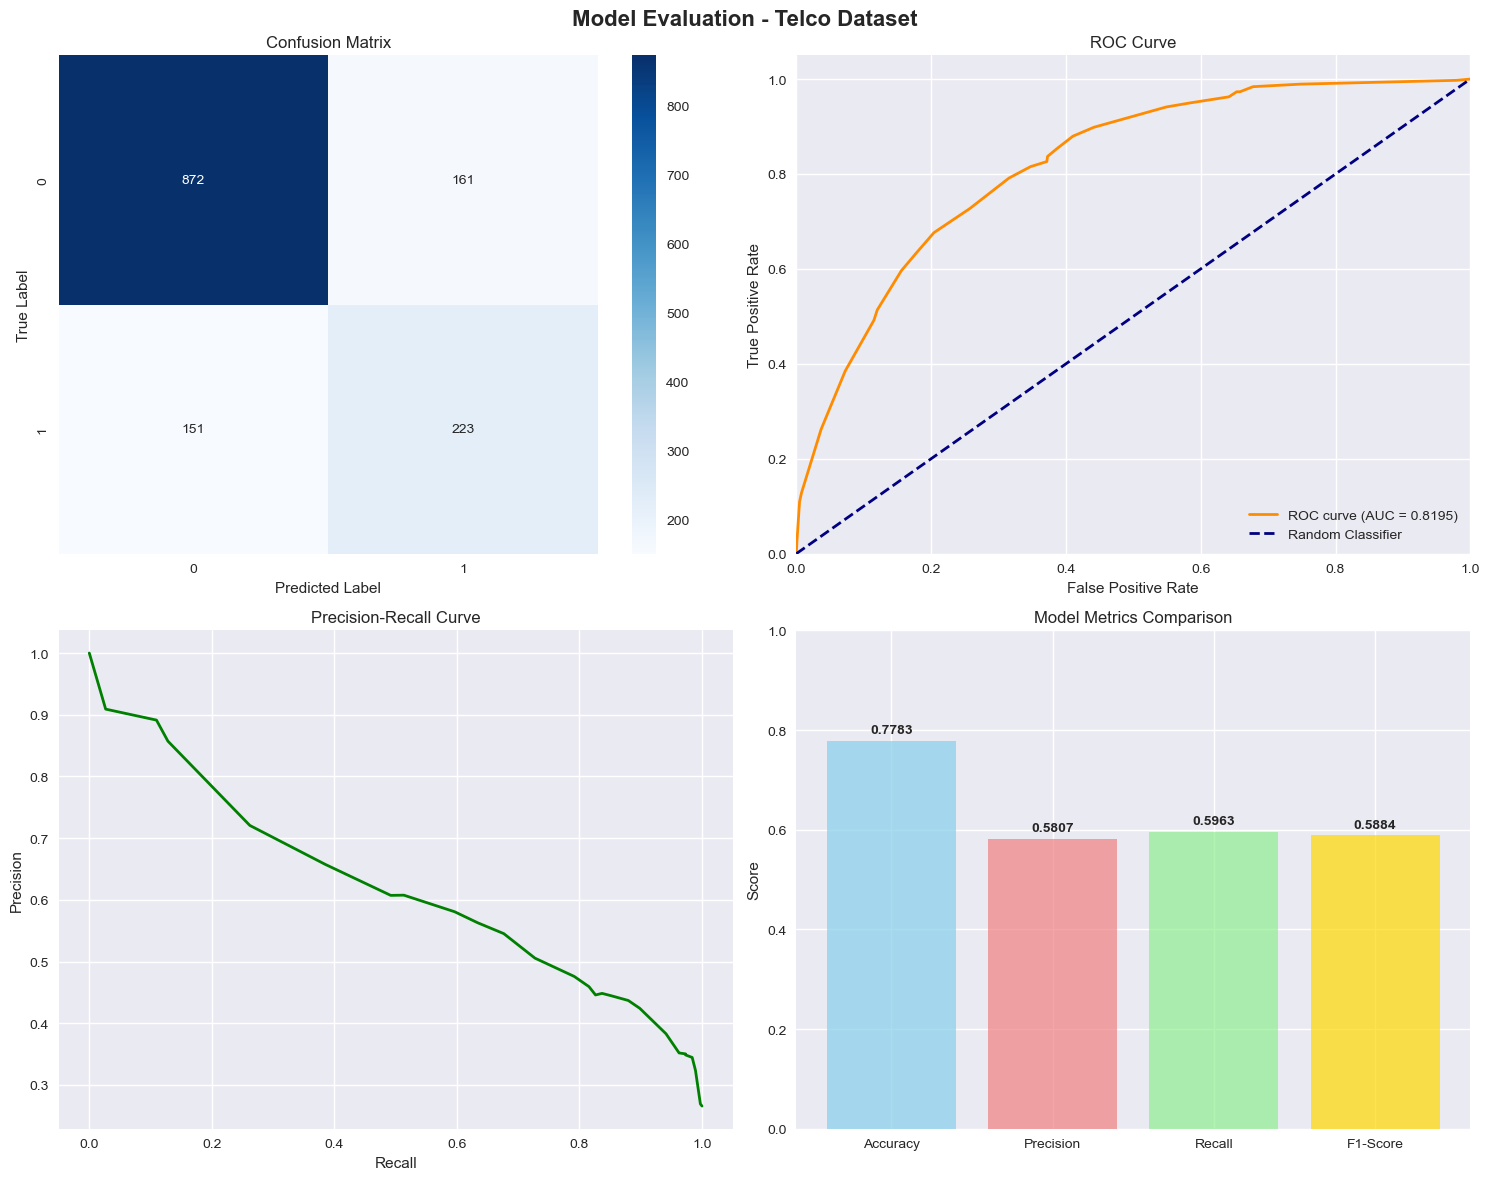


🔍 CROSS-VALIDATION RESULTS (5-fold):
   Accuracy:  0.7867 (+/- 0.0164)
   Precision: 0.6449 (+/- 0.0480)
   Recall:    0.4430 (+/- 0.1212)
   F1-Score:  0.5224 (+/- 0.0817)


In [11]:
# COMPREHENSIVE EVALUATION
print(f"\n{'='*70}")
print(f"📊 ASSIGNMENT REQUIREMENTS - COMPLETE MODEL EVALUATION")
print(f"{'='*70}")

# Evaluate model with all required metrics
evaluation_results = evaluate_model(dt_model, X_test, y_test, y_pred, y_pred_proba, 
                                  chosen_dataset.title())

# Cross-validation for model stability
cv_results = perform_cross_validation(dt_model, X_encoded, y, cv=5)

In [12]:
# Feature Importance (if available)
if hasattr(dt_model, 'feature_importances_'):
    print(f"\n🔍 TOP 10 FEATURE IMPORTANCES:")
    feature_importance = pd.DataFrame({
        'feature': X_encoded.columns,
        'importance': dt_model.feature_importances_
    }).sort_values('importance', ascending=False).head(10)
    
    print(feature_importance.to_string(index=False))

print(f"\n✅ CLASSIFICATION COMPLETE!")
print(f"📝 Evaluation metrics and visualizations have been generated.")
print(f"📊 Model trained and evaluated on: {chosen_dataset.title()} Dataset")


🔍 TOP 10 FEATURE IMPORTANCES:
                            feature  importance
                             tenure    0.441283
        InternetService_Fiber optic    0.338826
                       TotalCharges    0.033886
     PaymentMethod_Electronic check    0.026809
 OnlineSecurity_No internet service    0.026778
                     MonthlyCharges    0.025198
                  Contract_Two year    0.019312
StreamingMovies_No internet service    0.015402
                 OnlineSecurity_Yes    0.015138
                    TechSupport_Yes    0.012159

✅ CLASSIFICATION COMPLETE!
📝 Evaluation metrics and visualizations have been generated.
📊 Model trained and evaluated on: Telco Dataset


The decision tree classification algorithm performed ok. For the Customer dataset, the model was accurate (87.16%). However, it was fairly bad at detecting actual positives with the recall being 23.88%. When it did predict a positive, it was for the most part precise (72.73%) The F1-Score was low because of poor recall (35.96%). Overall, the AUC score for this model on this dataset was .7138. For the Telco dataset, it had a lower accuracy (77.83%) but it had a higher recall (59.63%), precision (58.07%), F1-Score (58.85%), and AUC Score (81.95%). The model produced both false positives and negatives with both datasets. The decision tree model performed better with the telco dataset. Below are the top three feature importance for both datasets.

Telco:
1. Tenure of being a customer
2. Fiber optic internet service
3. Total charges

Customer:
1. 5th campaign offer
2. The recency of last purchase
3. 3rd campaign offer